[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sachdevkartik/GSoC-2022/blob/main/test2.ipynb)


# __Classifying Dark Matter Substructure using Convolutional Visual Transformer (CvT)__


This approach uses Haiping Wu et al., <b> Convolutional vision Transformer (CvT) </b>, that combine the desirable properties of convolutional neural networks (CNNs) to the ViT architecture. It keeps CNN properties - shift, scale, and distortion invariance while maintaining the merits of Transformers - dynamic attention, global context, and better generalization. This enables to bring together the best of both designs.

This is accomplished through two primary modifications: a hierarchy of Transformers containing a new convolutional token embedding, and a convolutional Transformer block leveraging a convolutional projection. 

This resulted in a lightweight Vision transformer with around 0.46M parameters and a training time of approx 2 hours on Tesla K80 12 GB (Google Colab) with the given [dataset](https://drive.google.com/file/d/16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr/view?usp=sharing). The experiment with CvT opens up the door towards building lighter and faster models for the task in hand. 

## __Results__

| S.No | Metric | Value |
| --- | --- | --- |
| 1. | Best validation accuracy | 98.12% |
| 2. | AUC (with sub structure)  | 0.9988 |
| 3. | AUC (without sub structure)  | 0.9989 |



# __Google colab__
To run in Google colab, please execute the below cell for installing the requisite dependencies. The cell also clone the solution repo as it contains a custom file for Convolutional Vision Transformers (CvT). 

In [1]:
# !pip install  split-folders \
#               torchinfo \
#               einops \
#               e2cnn
# !pip install --upgrade --no-cache-dir gdown

In [2]:
# run in the case of Colab only
# %%bash
# set -m
# git clone https://github.com/sachdevkartik/GSoC-2022.git
# mv GSoC-2022/* . 
# rm -rf GSoC-2022

# __Running Locally__
To run locally, please execute the below cell for installing CUDA, pytorch among other dependencies and set up the conda env. If some of the dependcies are already installed like pytorch or cuda, please cherrypick dependencis from the ```setup.bash``` file

In [3]:
# %%bash
# bash setup.bash

# __Essential imports__

In [1]:
from __future__ import print_function
import os
from os import listdir
from os.path import join
import random
import logging
import time
import copy
import gdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import (RandomRotation, RandomCrop,
                                    Pad, Resize, RandomAffine,
                                    ToTensor, Compose, RandomPerspective)
from torchinfo import summary
from tqdm.notebook import tqdm
import splitfolders
from sklearn.metrics import roc_curve, auc, confusion_matrix

from cvt import CvT

## __Make required folders for data and models__

In [2]:
# check if the directory for data exists else make it
os.makedirs('data', exist_ok=True)
os.makedirs("model", exist_ok=True)

## __Download data__
A set of simulated strong gravitational lensing images with and without substructure. 

| S.No | Classes | # Images |
| --- | --- | --- |
| 1. | With substructure | 5000 |
| 2. | Without substructure | 5000 |

In [3]:
# check if the compressed data file from gdrive exist 
# else download in the directory
if not os.path.isfile('data/Model_I.tgz'):
    url = "https://drive.google.com/uc?id=1m7QzSzXyE8u_QoYplN9dIe-X2pf1KXxt" # https://drive.google.com/drive/folders/1m7QzSzXyE8u_QoYplN9dIe-X2pf1KXxt?usp=sharing
    output = "data/Model_I.tgz"
    gdown.download(url, output, quiet=False)
else:
    print("File exists")

File exists


## __Extract data__
Check if the compressed data file is already extracted else extract data, and create the train-test split (0.9:0.1). <br>

The data folder looks like: 

```bash
    lenses
    ├── train
    │   ├── no_sub
    │   └── sub
    └── val
        ├── no_sub
        └── sub
```

In [4]:
# initialize the data directory name  
data_dir = 'data/Model_I'

if os.path.isdir(data_dir):
    print("Extracted folder exists")
else:
    print("Extracting folder")
    os.system('tar xf data/Model_I.tgz --directory data ; mv data/Model_I data/Model_I_raw')
    splitfolders.ratio('data/Model_I_raw', output="data/Model_I", seed=1337, ratio=(.9, 0.1))
    os.system('rm -r data/Model_I_raw') 

Extracted folder exists


In [5]:
# %%bash

# set -m
# git clone https://github.com/sachdevkartik/GSoC-2022.git
# mv GSoC-2022/* . 
# rm -rf GSoC-2022

# data_dir_base = "/media/kartik/Elements/Kartik-Omen_Backup/Ubuntu/git/GSoC-2022/data"
# data_dir = "/media/kartik/Elements/Kartik-Omen_Backup/Ubuntu/git/GSoC-2022/data/Model_I"
# splitfolders.ratio(f'{data_dir_base}/Model_I_raw', output=data_dir, seed=1337, ratio=(.7, 0.3))
# os.system('rm -r data/Model_I_raw') 

In [6]:
# data_dir = "/media/kartik/Elements/Kartik-Omen_Backup/Ubuntu/git/GSoC-2022/data/Model_I"
data_dir =  "data/Model_I"

In [7]:
print(f"Torch: {torch.__version__}")

Torch: 1.6.0


## __Set Config and Hyperparameters__

In [8]:
# Data setting
n_classes = 3               # number of classes to be classified
image_size = 129            # image size (129x129)

# Training parameters
batch_size = 64             # batch size
epochs = 15                 # number of epochs
lr = 1e-4                   # learning rate

# optimizer parameters
weight_decay = 1e-7         # L2 penalty
gamma = 0.5                 # factor by which to decrease learning
step_size_opt = 20           # interval to apply optimizer scheduler 
use_lr_schedule = True     # To apply LR scheduler or not

seed = 42                   # fixing seed for repeatability
use_cuda = True             # Using CUDA
cuda_idx = 0                # idx of CUDA device to be used

In [9]:
def seed_everything(seed):
    """Fixing various seeds

    Args:
        seed (int): any seed number

    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

## __Select CUDA device for training__

In [10]:
def get_device(use_cuda=True, cuda_idx=0):
    """Get the CUDA device

    Args:
        use_cuda (Bool): To used CUDA or not
        cuda_idx (int): index of CUDA device 
    
    Returns:
        device: CUDA device(s) being used 
    """

    if use_cuda:
        if torch.cuda.is_available():
            assert cuda_idx in range(0, torch.cuda.device_count()),\
                "GPU index out of range. index lies in [{}, {})".format(0, torch.cuda.device_count())
            device = torch.device("cuda:"+str(cuda_idx))
        else:
            print("cuda not found, will switch to cpu")
    else:
        device = torch.device("cpu")
    print(f'Using device = {str(device)}')
    return device

In [11]:
device = get_device(use_cuda, cuda_idx)

Using device = cuda:0


## __Logger to save the results__

In [12]:
def init_logging_handler(log_dir, current_time, extra=''):
    """Initializes the handler for logger. Create the logger directory if it doest exists. 
        Define the format of logging
        DEBUG logging level being used

    Args:
        log_dir (str): Logger directory
        current_time (str): time from logging to begin  
        extra (str): Space for adding extra info in .txt file
    
    """

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    if not os.path.exists(os.path.join(log_dir, current_time)):
        os.makedirs(os.path.join(log_dir, current_time))

    stderr_handler = logging.StreamHandler()
    file_handler = logging.FileHandler('{}/{}/log_{}.txt'.format(
        log_dir, current_time, current_time + extra))
    logging.basicConfig(handlers=[stderr_handler, file_handler])
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    
logging.getLogger('matplotlib.font_manager').disabled = True

In [13]:
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir = 'logger'
init_logging_handler(log_dir, current_time)

## __Set the path for saving trained model name__

In [14]:
PATH = os.path.join("model", f"ConvTransformer_{current_time}.pt")

## __Transformations__ 

Transformers generally require a larger amount of data, thus, to compensate for lack of data, I rely on extensive data augmentation. Multiple transformation strategies were used and tested. <br>
Winning strategy:

1. Randomly crop to $128 \times 128$ 
2. Padded to increase to $129 \times 129$
3. Resized to $387 \times 387$
4. Randomly rotate between 0 $^{\circ}$ -180 $^{\circ}$ 
5. Random Affine in both orientation (20 $^{\circ}$ - 80 $^{\circ}$), translation (0.1 - 0.2) and scaling (0.4-0.95)
6. Random Perspective with distortion scale=0.3 and probability = 0.1
7. Resized to $129 \times 129$.
8. Converting to grayscale
9. Converting PIL image to tensor

Some parts of transformation were also refered from the existing implementation with equivariant networks.

__Tested Strategies__: <br>
Randomly select a predefined combination of transformation from a list e.g. transform1 & transform2 in order to have variation in training data. <br>
```RandAugment``` was also tested but did not give good results as it changed color statistics which are not present in test data. <br>
Also, no alteration in color setting was made as the data is more or less similar with respect to color statistics. 

In [15]:
# images are padded to have shape 129x129.
pad = Pad((0, 0, 1, 1), fill=0)
# to reduce interpolation artifacts
# upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(387)
resize2 = Resize(129)
totensor = ToTensor()
togray = transforms.Grayscale(num_output_channels=1)

In [16]:
def get_transform_train():

  random_transform = []

  transform1 = transforms.Compose([
      RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
      RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
      RandomPerspective(distortion_scale=0.3, p=0.1),
      ])
  
  transform2 = transforms.Compose([
      RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
      RandomAffine(degrees=(20, 80), translate=(0.1, 0.2), scale=(0.4, 0.95)),
      ])
  
  transform_list = [transform1, transform2]

  transform_prob = 1.0 / len(transform_list)
  for transform in transform_list:
      random_transform.append( transforms.RandomApply([transform], transform_prob) )


  transform_simple = Compose([
    #   transforms.RandomCrop(128),
    # pad,
    #   resize1,
    # RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
      resize2,
      togray,
      totensor,
  ])

  transform_train = Compose([
      transforms.RandomCrop(128),
      pad,
      resize1,
      RandomRotation(degrees=(0, 180), resample=Image.BILINEAR, expand=False),
      resize2,
      togray,
      totensor,
  ])
  return transform_simple

transform_test = Compose([
    # transforms.RandomCrop(128),
    # pad,
    resize2,
    togray,
    totensor,
])

## __Defining custom dataset for given data__

In [17]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, mode, transform=None):
        assert mode in ['train', 'test', 'val']

        self.root_dir = root_dir

        if mode == "train":
            self.root_dir = self.root_dir+"/train"
        elif mode == "test":
            self.root_dir = self.root_dir+"/test"
        else:
            self.root_dir = self.root_dir+"/val"

        self.transform = transform
        classes = listdir(self.root_dir) # [join(self.root_dir, x).split('/')[3] for x in listdir(self.root_dir)]
        classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.imagefilename = []
        self.labels = []
        
        for i in classes:
            for x in listdir(join(self.root_dir, i)):
                self.imagefilename.append(join(self.root_dir, i,x))
                self.labels.append(self.class_to_idx[i])

    
    def __getitem__(self, index):
        image, label = self.imagefilename[index], self.labels[index]
        
        image = np.load(image, allow_pickle=True)
        if label == 0:
            image = image[0]
        # image = image / image.max() #normalizes data in range 0 - 255
        # image = 255 * image
        image  = Image.fromarray(image.astype('uint8')) # .convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [18]:
trainset = CustomDataset(data_dir,'train',transform=get_transform_train()) # get_transform_train()
valset = CustomDataset(data_dir,'val',transform=transform_test) # transform_test

## __Dataloader__ 
Loading train and test data with shuffle and given batch size

In [19]:
train_loader = DataLoader(dataset = trainset, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valset, batch_size=batch_size, shuffle=True)

## __Visualize train image samples__

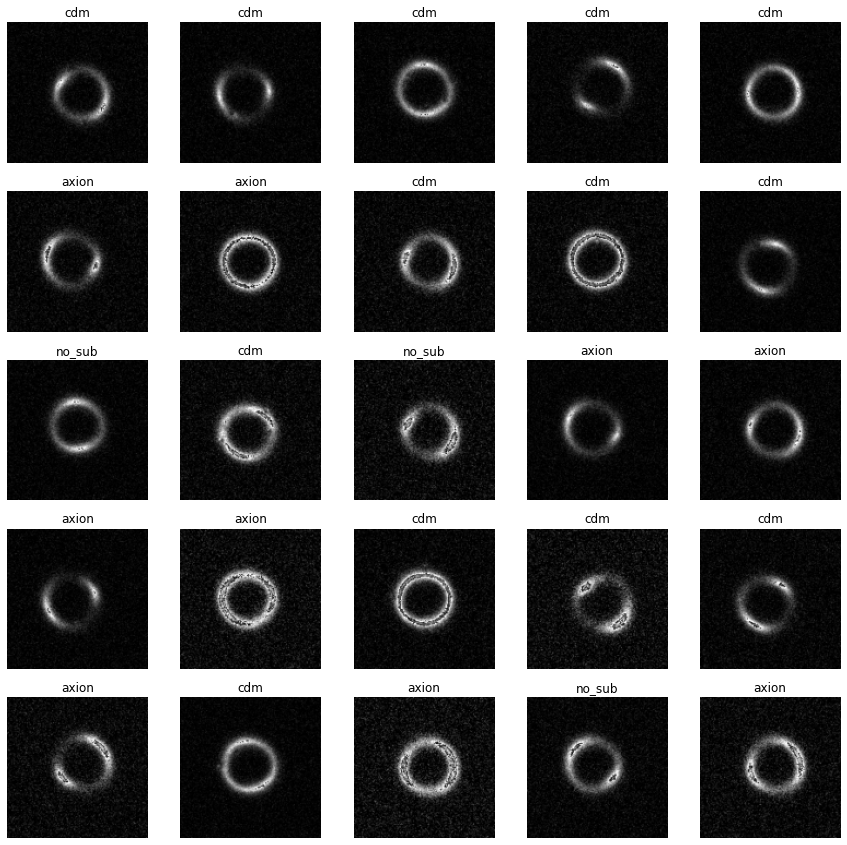

In [20]:
labels_map = {0: 'axion', 1:'cdm', 2:"no_sub"}
figure = plt.figure(figsize=(15, 15))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{labels_map[label]}")
    plt.axis("off")
    # im = transforms.ToPILImage()(img)
    img = img.squeeze()
    plt.imshow(img, cmap='gray')
    # plt.imshow(img)
plt.show()

In [21]:
# get the number of samples in train and test set
print(f"Train Data: {len(trainset)}")
print(f"Val Data: {len(valset)}")

Train Data: 61266
Val Data: 26259


### **Model Definition (CvT)**
This section graphically shows the architecture of the Convolutional Vision Transformer (CvT) used for binary classification.

![CvT](pictures/CvT%20architecture.png)
<!-- file:///home/kartik/git/GSoc2022_test/CvT%20architecture.png -->

<figcaption align = "center"><b>Hierarchical multi-stage structure facilitated by the Convolutional Token Embedding layer*</b></figcaption>

<br>

<p align="center">
  <img src="pictures/Convolutional%20Transformer%20Block.png">
  <figcaption align = "center"><b>Details of the Convolutional Transformer Block*</b></figcaption>
</p>

**source: Haiping Wu et al., Convolutional vision Transformer (CvT)* <br>
**Note: The CvT has been modified to make it more lighweight for the test purpose for compensating limited data*

## __Model Initialization__

In [22]:
# Lightweight CvT
v = CvT(
    channels = 1,           # channels - input channels of image
    num_classes = 3,        # classes - structure type
    s1_emb_dim = 64,        # stage 1 - dimension
    s1_emb_kernel = 7,      # stage 1 - conv kernel size
    s1_emb_stride = 4,      # stage 1 - conv stride
    s1_proj_kernel = 3,     # stage 1 - attention ds-conv kernel size
    s1_kv_proj_stride = 2,  # stage 1 - attention key / value projection stride
    s1_heads = 2,           # stage 1 - heads
    s1_depth = 3,           # stage 1 - depth
    s1_mlp_mult = 4,        # stage 1 - feedforward expansion factor
    s2_emb_dim = 128,       # stage 2 - (same as above)
    s2_emb_kernel = 3,
    s2_emb_stride = 2,
    s2_proj_kernel = 3,
    s2_kv_proj_stride = 2,
    s2_heads = 3,
    s2_depth = 2,
    s2_mlp_mult = 4,
    mlp_last = 256,
    dropout = 0.1
).to(device)

summary(v, input_size=(batch_size, 1, 129, 129))

Layer (type:depth-idx)                                                 Output Shape              Param #
CvT                                                                    --                        --
├─Sequential: 1-1                                                      [64, 3]                   --
│    └─Sequential: 2-1                                                 [64, 64, 33, 33]          --
│    │    └─Conv2d: 3-1                                                [64, 64, 33, 33]          3,200
│    │    └─LayerNorm: 3-2                                             [64, 64, 33, 33]          128
│    │    └─Transformer: 3-3                                           [64, 64, 33, 33]          202,752
│    └─Sequential: 2-2                                                 [64, 128, 17, 17]         --
│    │    └─Conv2d: 3-4                                                [64, 128, 17, 17]         73,856
│    │    └─LayerNorm: 3-5                                             [64, 128, 1

## __Defining optimizer__

In [23]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(v.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=weight_decay)
# scheduler
scheduler_plateau = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4, threshold=0.0000001, verbose=True)
scheduler_step = StepLR(optimizer, step_size=step_size_opt, gamma=gamma)

## __Training__

In [24]:
all_train_loss = []
all_val_loss = []
all_train_accuracy = []
all_val_accuracy = []
all_test_accuracy = []
all_epoch_loss = []

best_accuracy = 0

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    tr_loss_epoch = []
    running_loss = 0


    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = v(data)
        loss = criterion(output, label)
        epoch_loss += loss.item() 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_loss = epoch_loss / len(train_loader)
    all_epoch_loss.append(epoch_loss)

    correct = 0

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = v(data)
            val_loss = criterion(val_output, label)
 
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc 
            epoch_val_loss += val_loss 
            
        epoch_val_accuracy =epoch_val_accuracy / len(valid_loader)
        epoch_val_loss =epoch_val_loss / len(valid_loader)
        all_val_loss.append(epoch_val_loss)

    
    all_val_accuracy.append(epoch_val_accuracy.item()*100)
    logging.debug(        
        f"Epoch : {epoch+1} - LR {optimizer.param_groups[0]['lr']:.8f} - loss : {epoch_loss:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} \n"
    )

    if use_lr_schedule:
        # scheduler_plateau.step(epoch_val_loss)
        scheduler_step.step() 

    
    if epoch_val_accuracy > best_accuracy:
        best_accuracy = epoch_val_accuracy
        best_model = copy.deepcopy(v)  
        torch.save(best_model.state_dict(), PATH)

DEBUG:root:Epoch : 1 - LR 0.00010000 - loss : 0.8346 - val_loss : 0.4641 - val_acc: 0.8020 



DEBUG:root:Epoch : 2 - LR 0.00010000 - loss : 0.3957 - val_loss : 0.3600 - val_acc: 0.8481 



DEBUG:root:Epoch : 3 - LR 0.00010000 - loss : 0.3388 - val_loss : 0.3380 - val_acc: 0.8599 



DEBUG:root:Epoch : 4 - LR 0.00010000 - loss : 0.3166 - val_loss : 0.3179 - val_acc: 0.8654 



DEBUG:root:Epoch : 5 - LR 0.00010000 - loss : 0.3005 - val_loss : 0.2973 - val_acc: 0.8746 



DEBUG:root:Epoch : 6 - LR 0.00010000 - loss : 0.2902 - val_loss : 0.2891 - val_acc: 0.8775 



DEBUG:root:Epoch : 7 - LR 0.00010000 - loss : 0.2796 - val_loss : 0.2899 - val_acc: 0.8784 



DEBUG:root:Epoch : 8 - LR 0.00010000 - loss : 0.2692 - val_loss : 0.2905 - val_acc: 0.8770 



DEBUG:root:Epoch : 9 - LR 0.00010000 - loss : 0.2609 - val_loss : 0.2952 - val_acc: 0.8747 



DEBUG:root:Epoch : 10 - LR 0.00010000 - loss : 0.2574 - val_loss : 0.2884 - val_acc: 0.8799 



DEBUG:root:Epoch : 11 - LR 0.00010000 - loss : 0.2510 - val_loss : 0.2689 - val_acc: 0.8863 



DEBUG:root:Epoch : 12 - LR 0.00010000 - loss : 0.2455 - val_loss : 0.2697 - val_acc: 0.8859 



DEBUG:root:Epoch : 13 - LR 0.00010000 - loss : 0.2399 - val_loss : 0.2727 - val_acc: 0.8876 



DEBUG:root:Epoch : 14 - LR 0.00010000 - loss : 0.2375 - val_loss : 0.2731 - val_acc: 0.8861 



DEBUG:root:Epoch : 15 - LR 0.00010000 - loss : 0.2305 - val_loss : 0.2677 - val_acc: 0.8878 



# __Cite__

Inspired from: <br> <br> 
[CvT: Introducing Convolutions to Vision Transformers](https://arxiv.org/abs/2103.15808)


  ```
  @article{wu2021cvt,
    title={Cvt: Introducing convolutions to vision transformers},
    author={Wu, Haiping and Xiao, Bin and Codella, Noel and Liu, Mengchen and Dai, Xiyang and Yuan, Lu and Zhang, Lei},
    journal={arXiv preprint arXiv:2103.15808},
    year={2021}
  }
  ```

Apoorva Singh, Yurii Halychanskyi, Marcos Tidball, DeepLense, (2021), GitHub repository, https://github.com/ML4SCI/DeepLense

